A collection of deep learning models in JAX.

*   Author: Tianlin Liu
*   GitHub Repository: https://github.com/liutianlin0121/jax-deep-learning-models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/liutianlin0121/jax-deep-learning-models/blob/main/AE/ae-convnet-mnist.ipynb)


## Description

In this notebook, we will be training a ConvNet-based autoencoder on the MNIST dataset.

## Imports

In [1]:
if 'google.colab' in str(get_ipython()):
  %pip install ml-collections -q
  %pip install "jax[cuda11_cudnn82]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html -q
  %pip install flax -q

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import ml_collections
import optax

import torchvision
from torch.utils import data

## Prepare the MNIST dataset

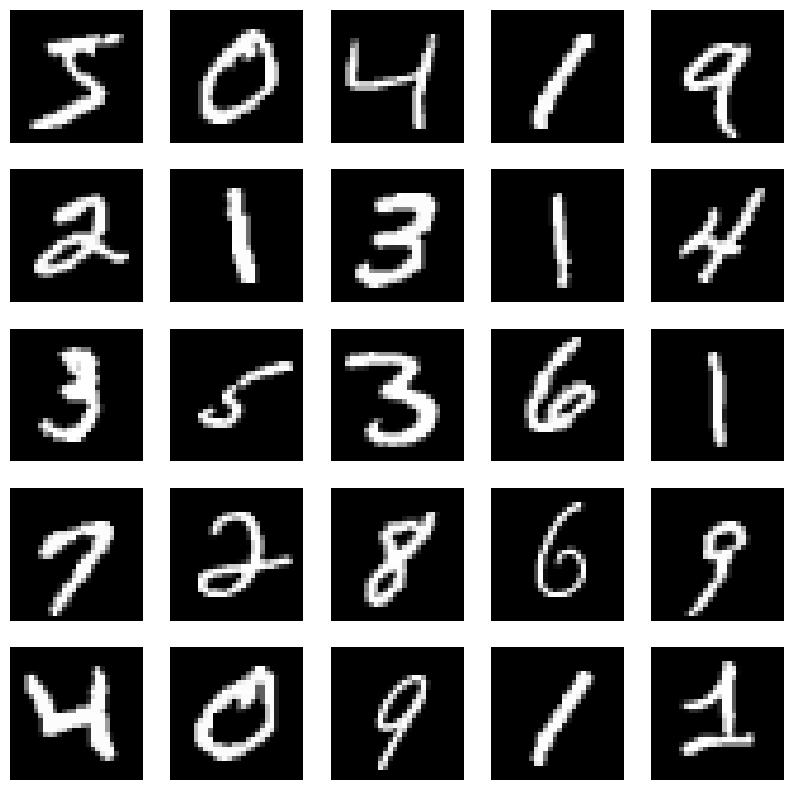

In [3]:
# Helper functions for images.
def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img.squeeze(), cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  if title:
    ax.set_title(title)


def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(2 * n, 2 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title)


def numpy_collate(batch):
  """Stack data into a numpy array.
  https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
  """
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple, list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)


class CastAndNormalize(object):
  """Cast and normalize an image.
  https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
  """
  def __call__(self, pic):
    return np.array(pic, dtype=jnp.float32)[..., np.newaxis] / 255

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets",
    train=True,
    transform=CastAndNormalize(),
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets",
    train=False,
    transform=CastAndNormalize(),
    download=True
)

show_img_grid(
  [train_dataset[idx][0].reshape((28, 28)) for idx in range(25)],
  [None for idx in range(25)],
)


## Set up the model and the training loop

The training loop setup here closely follows the the examples provided in the [flax repository](https://github.com/google/flax/tree/main/examples), sometimes verbatim.

In [4]:
class ConvEncoder(nn.Module):
  """Convolutional encoder."""

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=2, kernel_size=(3, 3))(x)
    # [B, N, N, 2]

    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2,2), strides=(2,2))
    # [B, N/2, N/2, 2]

    x = nn.Conv(features=4, kernel_size=(3, 3))(x)
    # [B, N/2, N/2, 4]

    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2,2), strides=(2,2))
    # [B, N/4, N/4, 4]
    return x

class ConvDecoder(nn.Module):
  """Convolutional decoder."""
  @nn.compact
  def __call__(self, x):
    x = nn.ConvTranspose(
      features=2, kernel_size=(3, 3), strides=(2,2))(x)
    # [B, N/2, N/2, 2]

    x = nn.relu(x)
    x = nn.ConvTranspose(
      features=2, kernel_size=(3, 3), strides=(2,2))(x)
    # [B, N, N, 2]

    x = nn.relu(x)
    x = nn.Conv(features=1, kernel_size=(1, 1))(x)
    # [B, N, N, 1]
    return x

class ConvAE(nn.Module):
  """A MLP autoencoder."""

  @nn.compact
  def __call__(self, x):
    latent = ConvEncoder()(x)
    recon = ConvDecoder()(latent)
    return recon, latent

In [5]:
rng = jax.random.PRNGKey(42)
convnet = ConvAE()
params = convnet.init(rng, jnp.ones([1, 28, 28, 1]))


In [6]:


@jax.jit
def apply_model(state, images, targets):
  """Computes gradients and loss for a single batch."""
  def loss_fn(params):
    recon, _ = state.apply_fn({'params': params}, images)
    loss = jnp.mean( (recon - targets) ** 2)
    return loss, recon

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, recon), grads = grad_fn(state.params)
  return grads, loss


@jax.jit
def update_model(state, grads):
  return state.apply_gradients(grads=grads)


def train_epoch(state, train_loader):
  """Train for a single epoch."""

  epoch_loss = []

  for batch_images, _ in train_loader:
    grads, loss = apply_model(state, batch_images, batch_images)
    state = update_model(state, grads)
    epoch_loss.append(loss)

  train_loss = np.mean(epoch_loss)
  return state, train_loss


def create_train_state(rng, config):
  """Creates initial `TrainState`."""
  convnet = ConvAE()
  params = convnet.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  tx = optax.adam(config.learning_rate)
  return train_state.TrainState.create(
    apply_fn=convnet.apply, params=params, tx=tx)


def train_and_evaluate(
  config: ml_collections.ConfigDict) -> train_state.TrainState:
  """Execute model training and evaluation loop.

  Args:
    config: Hyperparameter configuration for training and evaluation.

  Returns:
    The train state (which includes the `.params`).
  """
  train_loader = data.DataLoader(
    train_dataset, batch_size=config.batch_size,
    shuffle=True, num_workers=4, pin_memory=True,
    collate_fn=numpy_collate, drop_last=True)

  test_loader = data.DataLoader(
      test_dataset, batch_size=config.batch_size,
      shuffle=False, num_workers=4,
      collate_fn=numpy_collate, drop_last=True)

  rng = jax.random.PRNGKey(42)

  rng, init_rng = jax.random.split(rng)
  state = create_train_state(init_rng, config)

  for epoch in range(1, config.num_epochs + 1):
    state, train_loss = train_epoch(state, train_loader)

    test_loss_total = 0.0
    for images, _ in test_loader:
      _, test_loss_batch = apply_model(
        state, images, images)
      test_loss_total += test_loss_batch

    test_loss = test_loss_total / len(test_loader)
    print(
      f'epoch: {epoch:02d}/{config.num_epochs:02d} | ' +\
      f'train_loss: {train_loss:.4f} | ' +\
      f'test_loss: {test_loss: .4f} ')

  return state

## Training

In [7]:
config = ml_collections.ConfigDict()

config.learning_rate = 1e-3
config.batch_size = 128
config.num_epochs = 10

state = train_and_evaluate(config)

epoch: 01/10 | train_loss: 0.0778 | test_loss:  0.0273 
epoch: 02/10 | train_loss: 0.0212 | test_loss:  0.0177 
epoch: 03/10 | train_loss: 0.0168 | test_loss:  0.0158 
epoch: 04/10 | train_loss: 0.0157 | test_loss:  0.0151 
epoch: 05/10 | train_loss: 0.0152 | test_loss:  0.0147 
epoch: 06/10 | train_loss: 0.0148 | test_loss:  0.0144 
epoch: 07/10 | train_loss: 0.0145 | test_loss:  0.0140 
epoch: 08/10 | train_loss: 0.0141 | test_loss:  0.0137 
epoch: 09/10 | train_loss: 0.0139 | test_loss:  0.0135 
epoch: 10/10 | train_loss: 0.0138 | test_loss:  0.0134 


## Inference

In [8]:
test_images = jnp.array([test_data[0] for test_data in test_dataset])
test_labels = jnp.array([test_data[1] for test_data in test_dataset])

test_recons, test_latents = ConvAE().apply({'params': state.params}, test_images)

Text(0.5, 0.99, 'Orig image (top) and reconstruction (bottom)')

<Figure size 640x480 with 0 Axes>

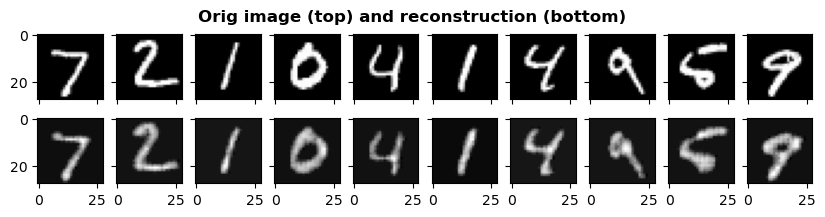

In [10]:
n_images = 10
image_width = 28

plt.figure()

fig, axes = plt.subplots(
  nrows=2,
  ncols=n_images,
  sharex=True,
  sharey=True,
  figsize=(n_images, 2))

orig_images = test_images[:n_images]
decoded_images = test_recons[:n_images]

for i in range(n_images):
  for ax, img in zip(axes, [orig_images, decoded_images]):
    curr_img = img[i]
    ax[i].imshow(curr_img.reshape((image_width, image_width)), cmap='gray')

plt.suptitle("Orig image (top) and reconstruction (bottom)",
             y=0.99, fontsize=12, fontweight="bold")